In [1]:
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm
from collections import OrderedDict

import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

e:\coding\github_pulls\GLPDepth\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils.logging as logging

from models.model import GLPDepth
from dataset.base_dataset import get_dataset

In [3]:
batch_size = 12
workers=8

ckpt_dir='ckpt/best_model_kitti.ckpt'

# choices=['nyudepthv2', 'kitti', 'imagepath']
dataset='imagepath'

# choices=['garg_crop', 'eigen_crop']
kitti_crop='eigen_crop'

max_depth=80.0
max_depth_eval=80.0
min_depth_eval=0.001
result_dir='results'
save_eval_pngs=False
save_visualize=False

In [4]:
data_path='datasets/raw_data/2011_09_26/2011_09_26_drive_0001_sync/image_02/data'
exp_name = 'test'

In [5]:
gpu_or_cpu = 'gpu'

if gpu_or_cpu == 'gpu':
    device = torch.device('cuda')
    cudnn.benchmark = True
else:
    device = torch.device('cpu')

In [6]:
result_path = os.path.join(result_dir, exp_name)
logging.check_and_make_dirs(result_path)
print("Saving result images in to %s" % result_path)

Saving result images in to results\test


In [7]:
print("\n1. Define Model")

model = GLPDepth(max_depth=max_depth, is_train=False).to(device)

model_weight = torch.load(ckpt_dir)

if 'module' in next(iter(model_weight.items()))[0]:
    model_weight = OrderedDict((k[7:], v) for k, v in model_weight.items())

model.load_state_dict(model_weight)
model.eval()


1. Define Model


GLPDepth(
  (encoder): mit_b4(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_features=64

In [8]:
print("\n2. Define Dataloader")

if dataset == 'imagepath': # not for do_evaluate in case of imagepath
    dataset_kwargs = {'dataset_name': 'ImagePath', 'data_path': data_path}
else:
    dataset_kwargs = {'data_path': data_path, 'dataset_name': dataset, 'is_train': False}

test_dataset = get_dataset(**dataset_kwargs)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)


2. Define Dataloader
Dataset : Image Path
# of images: 108


In [9]:
depth_images = []

print("\n3. Inference")

for batch_idx, batch in enumerate(test_loader):
    input_RGB = batch['image'].to(device)
    filename = batch['filename']

    with torch.no_grad():
        pred = model(input_RGB)

    pred_d = pred['pred_d']

    save_path = os.path.join(result_path, filename[0])

    pred_d_numpy = pred_d.squeeze().cpu().numpy()
    pred_d_numpy = (pred_d_numpy / pred_d_numpy.max()) * 255
    pred_d_numpy = pred_d_numpy.astype(np.uint8)
    pred_d_color = cv2.applyColorMap(pred_d_numpy, cv2.COLORMAP_RAINBOW)

    depth_images.append(cv2.cvtColor(pred_d_color, cv2.COLOR_BGR2RGB))

    logging.progress_bar(batch_idx, len(test_loader), 1, 1)


3. Inference
 [=============================>]  Step: 096ms | Tot: 09s865ms | Rem: 289ms     106/108 ............................]  Step: 092ms | Tot: 642ms | Rem: 09s315ms     8/108 ==>...........................]  Step: 099ms | Tot: 841ms | Rem: 09s864ms     10/108 ===>..........................]  Step: 088ms | Tot: 01s036ms | Rem: 08s627ms  12/108 ===>..........................]  Step: 097ms | Tot: 01s226ms | Rem: 09s248ms  14/108 ====>.........................]  Step: 093ms | Tot: 01s411ms | Rem: 08s668ms  16/108 ====>.........................]  Step: 091ms | Tot: 01s593ms | Rem: 08s365ms  18/108 =====>........................]  Step: 093ms | Tot: 01s687ms | Rem: 08s425ms  19/108 ======>.......................]  Step: 089ms | Tot: 02s331ms | Rem: 07s467ms  26/108 =======>......................]  Step: 090ms | Tot: 02s422ms | Rem: 07s452ms  27/108 =======>......................]  Step: 089ms | Tot: 02s604ms | Rem: 07s143ms  29/108 ========>.....................]  Step: 091ms | Tot:

In [10]:
# save as png images

for i, depth_image in tqdm(enumerate(depth_images)):
    cv2.imwrite(os.path.join(result_path, '%05d.png' % i), depth_image)

108it [00:00, 146.96it/s]


In [11]:
images_raw = glob.glob("datasets\\raw_data\\2011_09_26\\2011_09_26_drive_0001_sync\\image_02\\data\\*.png")
images_depth = glob.glob("results\\test\\*.png")

In [16]:
stacked = []

for i in tqdm(range(len(images_raw))):
    img1 = cv2.imread(images_raw[i])
    img2 = cv2.imread(images_depth[i])

    if img1.shape[0] != img2.shape[0]:
        # resize by removing excess pixels left and right
        img1 = img1[:, :img2.shape[1], :]
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    elif img1.shape[1] != img2.shape[1]:
        # resize by removing excess pixels top and bottom
        img1 = img1[:img2.shape[0], :, :]

    vis = np.concatenate((img1, img2), axis=0)

    # resize to 50% of original size
    vis = cv2.resize(vis, (int(vis.shape[1] / 3), int(vis.shape[0] / 3)))
    
    stacked.append(vis)

100%|██████████| 108/108 [00:01<00:00, 54.14it/s]


In [17]:
import imageio

# imageio.mimsave('depth_images.gif', depth_images, fps=15)

imageio.mimsave('stacked_images.gif', stacked, fps=10)

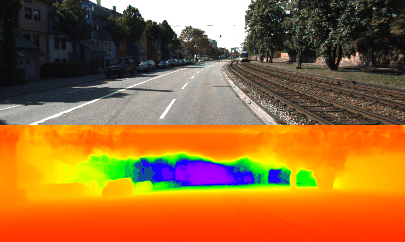

In [18]:
from IPython.display import Image

Image(filename='stacked_images.gif')